In [78]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import os

In [79]:
#Carga del archivo
df_nvo_prod=pd.read_excel("C:/Users/marib/CasoIBP/Nvosproductos.xlsx")
df_nvo_prod

,ID,Producto,Responsable,Cliente,Fecha de inicio,Fecha de cierre,Estado,Categoria,Probabilidad,Nvo Desarrollo,Precio,Volumen,Venta,unidad de medida,Gross Margin,Canal
0,Nvo 2652,Producto2652,Alex,Cliente82,2023-03-17,2023-05-31,Abierto,Categoria8,0 %,No,60.00,1000,60000.0,kg,45.00,Canal2
1,Nvo 2653,Producto2653,Daniel,Cliente110,2023-03-17,2023-09-30,Abierto,Categoria10,0 %,No,54.24,1000,54240.0,kg,40.68,Canal2
2,Nvo 2655,Producto2655,Daniel,Cliente49,2023-03-21,2023-06-19,Abierto,Categoria13,0 %,No,38.00,13000,494000.0,kg,28.50,Canal2
3,Nvo 2656,Producto2656,Daniel,Cliente10,2023-03-21,2023-06-19,Abierto,Categoria2,0 %,No,38.00,13000,494000.0,kg,28.50,Canal2
4,Nvo 2874,Producto2874,Lalo,Cliente111,2023-02-13,2023-05-14,Abierto,Categoria13,0 %,No,100.00,24000,2400000.0,kg,75.00,Canal2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Nvo 3289,Producto3289,Alex,Cliente91,2023-03-01,2023-05-30,Abierto,Categoria3,0 %,No,100.00,5000,500000.0,kg,75.00,Canal2
66,Nvo 3297,Producto3297,Uriel,Cliente113,2023-03-04,2023-06-02,Abierto,Categoria3,15 %,No,100.00,180000,18000000.0,kg,75.00,Canal2
67,Nvo 3298,Producto3298,Gerry,Cliente32,2023-03-21,2024-04-10,Abierto,Categoria7,10 %,No,40.00,500,20000.0,kg,30.00,Canal2
68,Nvo 3304,Producto3304,Alex,Cliente111,2023-02-21,2023-04-30,En proceso,Categoria4,0 %,No,26.00,600,15600.0,kg,19.50,Canal2


In [80]:
#**Paso 1. Preprocesamiento del archivo**

df_nvo_prod.columns = df_nvo_prod.columns.str.strip().str.replace(" ", "_")
df_nvo_prod['Fecha_de_inicio'] = pd.to_datetime(df_nvo_prod['Fecha_de_inicio'], dayfirst = True, errors='coerce')
df_nvo_prod['Fecha_de_cierre'] = pd.to_datetime(df_nvo_prod['Fecha_de_cierre'], dayfirst=True, errors='coerce')
df_nvo_prod['Probabilidad'] = df_nvo_prod['Probabilidad'].str.replace('%','').astype(float)/100
df_nvo_prod['Nvo_Desarrollo'] = df_nvo_prod['Nvo_Desarrollo'].map({'Sí':True, 'No':False})
df_nvo_prod['Gross_Margin'] = df_nvo_prod['Gross_Margin'].astype(float)
df_nvo_prod['Precio']=df_nvo_prod['Precio'].astype(float)
df_nvo_prod['Volumen']=df_nvo_prod['Volumen'].astype(float)
df_nvo_prod['Venta']=df_nvo_prod['Venta'].astype(float)


In [81]:
#Paso 2. Derivar variables
df_nvo_prod['Margen_esperado'] = df_nvo_prod['Gross_Margin']*df_nvo_prod['Venta']
df_nvo_prod['Valor_esperado'] = df_nvo_prod['Probabilidad']*df_nvo_prod['Venta']

In [82]:
#Paso 3. Revisión general

print(df_nvo_prod.info())
print(df_nvo_prod.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID                70 non-null     object        
 1   Producto          70 non-null     object        
 2   Responsable       70 non-null     object        
 3   Cliente           70 non-null     object        
 4   Fecha_de_inicio   70 non-null     datetime64[ns]
 5   Fecha_de_cierre   70 non-null     datetime64[ns]
 6   Estado            70 non-null     object        
 7   Categoria         70 non-null     object        
 8   Probabilidad      70 non-null     float64       
 9   Nvo_Desarrollo    70 non-null     bool          
 10  Precio            70 non-null     float64       
 11  Volumen           70 non-null     float64       
 12  Venta             70 non-null     float64       
 13  unidad_de_medida  70 non-null     object        
 14  Gross_Margin      70 non-nul

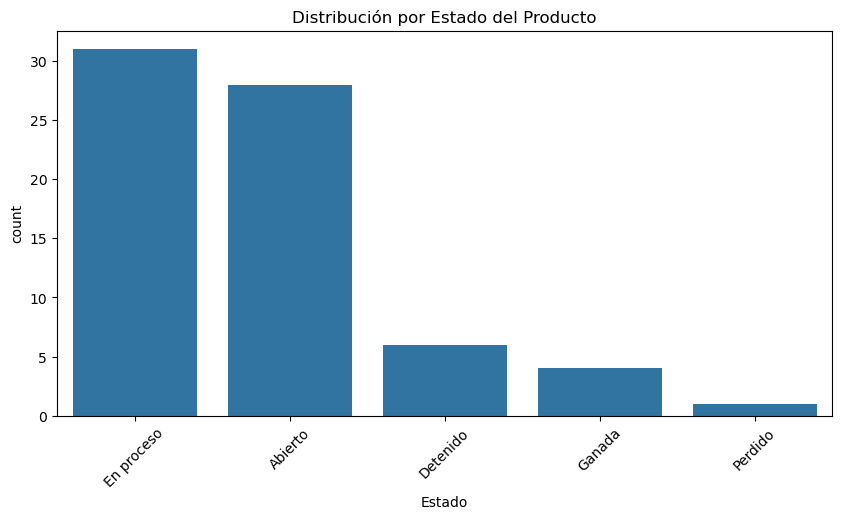

In [83]:
#Paso 4. Producto por estado

plt.figure(figsize=(10,5))
sns.countplot(data=df_nvo_prod, x='Estado', order=df_nvo_prod['Estado'].value_counts().index)
plt.title('Distribución por Estado del Producto')
plt.xticks(rotation=45)
plt.show()

In [84]:
#Paso 5. Volumen y margen por categoría
df_margen = df_nvo_prod.groupby('Categoria').agg({
    'Volumen':'sum',
    'Margen_esperado':'sum',
    'Valor_esperado':'sum'
}).sort_values('Valor_esperado',ascending=False)

df_margen


,Volumen,Margen_esperado,Valor_esperado
Categoria,,,
Categoria13,539100.0,7.560394e+08,11983950.0
Categoria11,5090360.0,2.520965e+08,8306268.0
Categoria8,195300.0,4.530608e+08,7591350.0
Categoria6,96400.0,4.892790e+08,5855160.0
Categoria10,146000.0,6.349474e+08,5547750.0
Categoria3,190100.0,1.397524e+09,2932200.0
Categoria14,17000.0,2.276310e+08,1304250.0
Categoria17,15300.0,1.183425e+08,974000.0
Categoria16,19400.0,6.735764e+07,951162.0


In [85]:
#Normalización y score
#Copia del dataset para analisis

df_score = df_nvo_prod.copy()

#Variables a normalizar
vars_norm = ['Valor_esperado','Margen_esperado','Volumen', 'Probabilidad']
scaler = MinMaxScaler()
df_score[vars_norm] = scaler.fit_transform(df_score[vars_norm])

#Estado ordinal

estado_orden = {   
    'Abierto': 0.5,
    'Detenido': 0.2,
    'En proceso': 0.7,
    'Ganada': 1.0,
    'Perdido': 0.0
}


df_score['Estado_score'] = df_score['Estado'].map(estado_orden)

#Calculo score final
df_score['Score_Prioridad'] = (
    0.40 * df_score['Valor_esperado']+
    0.25 * df_score['Margen_esperado']+
    0.15 * df_score['Volumen']+
    0.10 * df_score['Probabilidad']+
    0.10 * df_score['Estado_score']
)

#Ordenamos por score

df_score = df_score.sort_values('Score_Prioridad', ascending=False)

#Mostrar los top 10
df_score[['Producto','Categoria','Score_Prioridad','Valor_esperado','Margen_esperado','Estado']].head(10)
    


,Producto,Categoria,Score_Prioridad,Valor_esperado,Margen_esperado,Estado
12,Producto2963,Categoria13,0.571484,1.000000,0.149947,Abierto
27,Producto3219,Categoria11,0.507734,0.660741,0.013752,Abierto
22,Producto3171,Categoria6,0.504860,0.802667,0.345106,Detenido
66,Producto3297,Categoria3,0.480397,0.400000,1.000000,Abierto
53,Producto3270,Categoria8,0.462528,0.677333,0.171991,En proceso
42,Producto3259,Categoria11,0.405126,0.541333,0.164784,En proceso
54,Producto3271,Categoria13,0.383141,0.508000,0.128978,En proceso
51,Producto3268,Categoria10,0.380510,0.503000,0.126450,En proceso
40,Producto3257,Categoria8,0.352566,0.433978,0.127969,En proceso
31,Producto3230,Categoria13,0.221009,0.160000,0.066608,Abierto


In [86]:
#Visualización del score

import plotly.express as px

fig = px.bar(
    df_score.sort_values('Score_Prioridad', ascending=False).head(15),
    x='Producto',
    y='Score_Prioridad',
    color='Categoria',
    hover_data=['Valor_esperado', 'Margen_esperado', 'Estado'],
    title='Top 15 Nuevos Productos Priorizados'
)
fig.show()

C:\Users\marib\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\marib\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\marib\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\marib\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

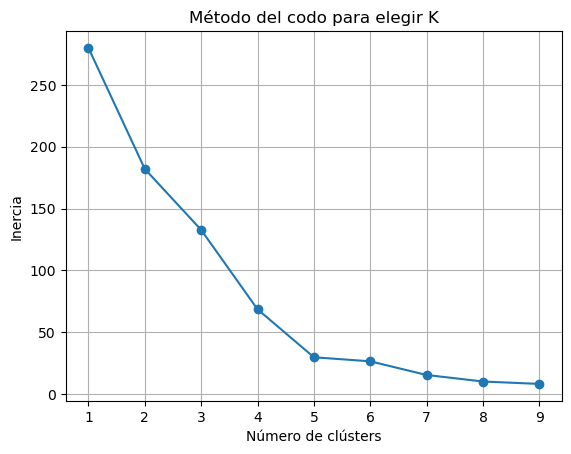

C:\Users\marib\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



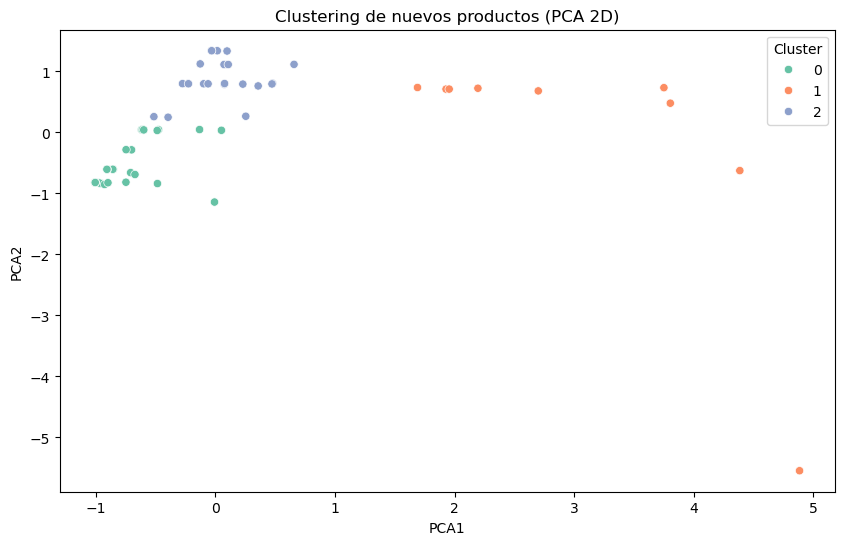

,Valor_esperado,Margen_esperado,Volumen
Cluster,,,
0,4.493316e+04,2.897944e+07,15293.684211
1,4.145289e+06,3.344098e+08,667800.000000
2,3.451257e+05,3.801317e+07,6347.826087


In [87]:
#Clustering de nuevos productos

#Variables para clustering

features = df_nvo_prod[['Valor_esperado','Margen_esperado','Volumen','Probabilidad']]

#Escalar datos
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

#Elegir número óptimo de clústeres (Elbow Method)
inertia = []
for k in range(1,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    inertia.append(km.inertia_)

plt.plot(range(1,10), inertia, marker='o')
plt.title("Método del codo para elegir K")
plt.xlabel("Número de clústers")
plt.ylabel("Inercia")
plt.grid()
plt.show()

#Ajuste del modelo con k óptimo
kmeans = KMeans(n_clusters=3, random_state=42)
df_nvo_prod['Cluster']= kmeans.fit_predict(scaled_features)

#Visualización en 2D (PCA)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
df_nvo_prod['PCA1'] = pca_components[:,0]
df_nvo_prod['PCA2'] = pca_components[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_nvo_prod, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("Clustering de nuevos productos (PCA 2D)")
plt.show()

#Revisamos productos por grupo
df_nvo_prod.groupby('Cluster')[['Valor_esperado', 'Margen_esperado', 'Volumen']].mean()

In [88]:
#Calcular promedios por clúster
promedios_cluster = df_nvo_prod.groupby('Cluster')[['Valor_esperado', 'Margen_esperado', 'Volumen']].mean().reset_index()

#Exportar a Excel con dos hojas
with pd.ExcelWriter("clustering_nuevos_productos.xlsx", engine='xlsxwriter') as writer:
    df_nvo_prod.to_excel(writer, sheet_name="Datos Clusterizados", index=False)
    promedios_cluster.to_excel(writer, sheet_name="Promedios por Cluster", index=False)



In [89]:
#Analisis por responsable (Comercial)

df = df_nvo_prod.copy()

#Mapeo de estados a score

estado_score = {
    'Ganada': 1.0,
    'En proceso': 0.7,
    'Abierto': 0.5,
    'Detenido': 0.2,
    'Perdido': 0.0
}

# Normaliza texto y asigna score

df['Estado'] = df['Estado'].str.strip().str.title()  # Asegura formato uniforme
df['Score_cierre'] = df['Estado'].map(estado_score)

# Agrupar por responsable
resumen = df.groupby('Responsable').agg(
    Total_Proyectos=('Estado', 'count'),
    Score_Promedio=('Score_cierre', 'mean'),
    Proyectos_Ganados=('Estado', lambda x: (x == 'Ganada').sum()),
    Proyectos_En_Proceso=('Estado', lambda x: (x == 'En Proceso').sum()),
    Proyectos_Perdidos=('Estado', lambda x: (x == 'Perdido').sum())
).sort_values(by='Score_Promedio', ascending=False)

resumen.reset_index(inplace=True)
print(resumen)

   Responsable  Total_Proyectos  Score_Promedio  Proyectos_Ganados  \
0       Genaro                6        0.666667                  1   
1      Dolores                5        0.600000                  1   
2         Lalo                7        0.600000                  1   
3         Alex               10        0.583333                  1   
4        Diego                2        0.500000                  0   
5         Jose                4        0.500000                  0   
6         Lili                4        0.500000                  0   
7       Manuel                2        0.500000                  0   
8        Uriel                3        0.500000                  0   
9       Daniel                8        0.425000                  0   
10    Fernando                4        0.400000                  0   
11       Gerry               11        0.316667                  0   
12      Renata                3        0.200000                  0   
13       Paola      

In [90]:
df_nvo_prod=pd.read_excel("C:/Users/marib/CasoIBP/Nvosproductos.xlsx")
df_train = df_nvo_prod.copy()

#Filtramos proyectos con estado ganado o perdido
df  = df_train[df_train['Estado'].isin(['Ganada','Perdido'])].copy()
df['Estado_Binario'] = df['Estado'].apply(lambda x: 1 if x == 'Ganada' else 0)

#Selección de columnas relevantes para el analisis
columnas_modelo = [
    'Responsable', 'Cliente', 'Categoria', 'Nvo Desarrollo',
    'Precio', 'Volumen', 'Venta', 'Gross Margin', 'Canal', 'Probabilidad'
]

df_modelo = df[columnas_modelo + ['Estado_Binario']].dropna(subset=columnas_modelo + ['Estado_Binario'])


#Codificar variables categoricas
label_encoders = {}
for col in columnas_modelo:
    le = LabelEncoder()
    df_modelo[col] = le.fit_transform(df_modelo[col])
    label_encoders[col]= le

#Separar variables y target
X = df_modelo[columnas_modelo]
y = df_modelo['Estado_Binario']

#Dividimos en entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Entrenar modelo Random Forest
clf = RandomForestClassifier(n_estimators=10, random_state=42)
clf.fit(X_train, y_train)

#Evaluar el modelo
y_pred = clf.predict(X_test)
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

#Importancia de variables
importancia = pd.DataFrame({'Variable':X.columns, 'Importancia': clf.feature_importances_})
importancia.sort_values(by='Importancia', ascending = True, inplace=True)


C:\Users\marib\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

Matriz de confusión:
 [[0 1]
 [0 1]]


C:\Users\marib\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\marib\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [91]:
columnas_filtradas = [
    'Responsable', 'Cliente', 'Categoria',
    'Precio', 'Volumen', 'Venta',
    'Gross Margin', 'Probabilidad'
]

X = df_modelo[columnas_filtradas]
y = df['Estado_Binario']

modelo = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
modelo.fit(X, y)

importancias = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': modelo.feature_importances_
}).sort_values(by='Importancia', ascending=False)

print(importancias)

       Variable  Importancia
7  Probabilidad     0.211940
2     Categoria     0.178109
5         Venta     0.152018
4       Volumen     0.122575
1       Cliente     0.104291
0   Responsable     0.099613
3        Precio     0.092648
6  Gross Margin     0.038806


In [92]:
df.groupby('Responsable')['Estado_Binario'].mean()

Responsable
Alex       1.0
Dolores    1.0
Genaro     1.0
Gerry      0.0
Lalo       1.0
Name: Estado_Binario, dtype: float64

In [93]:
tabla_cruzada = df.pivot_table(
    values='Estado_Binario',
    index='Cliente',
    columns='Categoria',
    aggfunc='mean'
).fillna(0)

print(tabla_cruzada)

Categoria   Categoria1  Categoria15  Categoria16  Categoria17  Categoria3
Cliente                                                                  
Cliente110         0.0          0.0          0.0          0.0         1.0
Cliente111         0.0          0.0          1.0          0.0         0.0
Cliente32          0.0          0.0          0.0          1.0         0.0
Cliente40          0.0          0.0          0.0          0.0         0.0
Cliente69          1.0          0.0          0.0          0.0         0.0


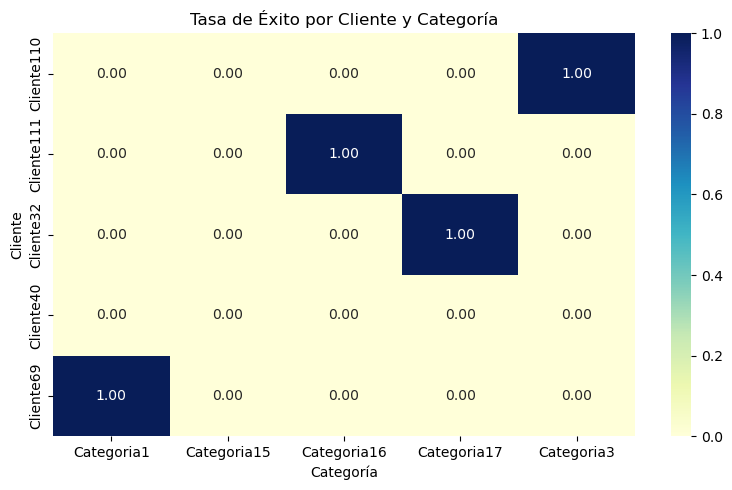

In [94]:
plt.figure(figsize=(8, 5))
sns.heatmap(tabla_cruzada, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Tasa de Éxito por Cliente y Categoría")
plt.ylabel("Cliente")
plt.xlabel("Categoría")
plt.tight_layout()
plt.show()

In [95]:
with pd.ExcelWriter('analisis_nvos_productos.xlsx') as writer:
    df_margen.to_excel(writer, sheet_name='Margen_volumen', index=False)
    df_score.to_excel(writer, sheet_name='Score', index=False)
    df_nvo_prod.to_excel("clustering_nuevos_productos.xlsx", index=False)
    resumen.to_excel('resumen_comercial.xlsx', index=False)
    importancia.to_excel('resumen_comercial.xlsx', index=False)
    importancias.to_excel('resumen_comercial.xlsx', index=False)
    tabla_cruzada.to_excel('resumen_comercial.xlsx', index=False)
